In [101]:
import pandas as pd
import numpy as np
import re
from pprint import pprint
import collections
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import models
from keras import layers
import json
from nltk.corpus import stopwords

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import os

In [116]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['http', 'bully', 'bullying'])
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [117]:
df = pd.read_csv('../data/english_labels_with_tweets.csv')
print(df.Emotion.unique())
emotions=['anger', 'relief', 'sadness', 'empathy', 'pride', 'other']

df = df.loc[df['Emotion'].isin(emotions)]
print(df.Emotion.unique())
print(df)

['none' nan 'anger' 'relief' 'sadness' 'empathy' 'pride' 'other']
['anger' 'relief' 'sadness' 'empathy' 'pride' 'other']
                Tweet ID    User ID Bullying_Traces?             Type   Form  \
80    105946088254619648   20151008                y       accusation  other   
98    105239503526043649  199288197                y  self-disclosure  other   
126   101483313612587008   94043537                y       accusation  other   
144   108415123839913984   24828721                y  self-disclosure  other   
182   100989100592599040  129903842                y  self-disclosure  other   
...                  ...        ...              ...              ...    ...   
2254  102174578519982080  307562787                y  self-disclosure  other   
2328  103085289492324355  288212914                y           report  other   
2336  108691272751001600   77786440                y       accusation  other   
2373  102766332814180355   78319048                y  self-disclosure  other   

In [118]:
# Convert to list
data = df.Text.values.tolist()

#remove links
data = [re.sub(r"http\S+", "", sent) for sent in data]

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['i love your stomp out bullying video! very inspirational(: i think i will '
 'enter...♥ ']


In [119]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=False))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['love', 'your', 'stomp', 'out', 'bullying', 'video', 'very', 'inspirational', 'think', 'will', 'enter']]


In [120]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['love', 'your', 'stomp', 'out', 'bullying', 'video', 'very', 'inspirational', 'think', 'will', 'enter']


C:\Users\erajkovic\Anaconda3\envs\tensorflow_env\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [121]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def remove_no_dict_words(texts):
    return [[word for word in doc if word in glove_dict] for doc in texts]
    
GLOVE_DIM=100
glove_file = 'C:/Users/erajkovic/Downloads/glove.twitter.27B/glove.twitter.27B.100d.txt'
glove_dict = []
NB_WORDS = 4525   # duljina file-a vocab
glove = open(glove_file, encoding="utf8")
for line in glove:
    values = line.split()
    word = values[0]
    glove_dict.append(word)
glove.close()
print(glove_dict[:3])

['<user>', '.', ':']


In [130]:
# Remove Stop Words
data_words_nodict = remove_no_dict_words(data_words)
data_words_nostops = remove_stopwords(data_words_nodict)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized = remove_stopwords(data_lemmatized)

print(data_lemmatized[:1])


[['love', 'stomp', 'video', 'inspirational', 'think', 'enter']]


In [131]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


[[('enter', 1),
  ('inspirational', 1),
  ('love', 1),
  ('stomp', 1),
  ('think', 1),
  ('video', 1)]]

In [132]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [133]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.020*"kwangsoo" + 0.020*"underdog" + 0.020*"remove" + 0.020*"beatdown" + '
  '0.011*"lol" + 0.011*"twitter" + 0.011*"love" + 0.011*"tellin" + '
  '0.011*"still" + 0.011*"realize"'),
 (1,
  '0.052*"get" + 0.027*"twitter" + 0.014*"school" + 0.014*"say" + 0.014*"grip" '
  '+ 0.014*"word" + 0.014*"easy" + 0.014*"really" + 0.014*"mouth" + '
  '0.014*"shut"'),
 (2,
  '0.022*"time" + 0.015*"read" + 0.015*"anti" + 0.015*"alsatian" + 0.015*"go" '
  '+ 0.015*"post" + 0.015*"cyber" + 0.008*"alex" + 0.008*"get" + 0.008*"real"'),
 (3,
  '0.021*"feel" + 0.021*"watch" + 0.021*"wrong" + 0.021*"think" + '
  '0.021*"american" + 0.011*"person" + 0.011*"allow" + 0.011*"embrace" + '
  '0.011*"authentic" + 0.011*"turn"'),
 (4,
  '0.021*"ad" + 0.021*"dem" + 0.021*"lol" + 0.011*"ms" + 0.011*"spark" + '
  '0.011*"explain" + 0.011*"fear" + 0.011*"sweet" + 0.011*"complaint" + '
  '0.011*"yesterday"'),
 (5,
  '0.020*"take" + 0.020*"need" + 0.014*"nice" + 0.014*"abuse" + 0.014*"hater" '
  '+ 0.014*"day" +

In [134]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.476184224318235

Coherence Score:  0.45883110419040857


In [135]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.109726  0.107094       1        1  26.393168
2      0.134113  0.072528       2        1  23.645381
0      0.011393 -0.072438       3        1  15.138863
3     -0.035921 -0.081452       4        1  13.942243
4      0.005725 -0.019469       5        1  13.192082
1     -0.005584 -0.006263       6        1   7.688262, topic_info=         Term      Freq     Total Category  logprob  loglift
186       get  2.000000  2.000000  Default  30.0000  30.0000
96    twitter  1.000000  1.000000  Default  29.0000  29.0000
35      wrong  2.000000  2.000000  Default  28.0000  28.0000
29       feel  3.000000  3.000000  Default  27.0000  27.0000
173       lol  2.000000  2.000000  Default  26.0000  26.0000
..        ...       ...       ...      ...      ...      ...
180      fail  0.062087  1.071550   Topic6  -6.1799  -0.2828
173       lol  0.062086  2.077232   Topic6  -6.1799  -0.9448
77       need  0.062084  2.523112   Topic6  -6.1799  -1.1393
62   american  0.062084  1.568178   Topic6  -6.1799  -0.6637
91         go  0.062084  3.137544   Topic6  -6.1799  -1.3572

[263 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
36        1  0.417471      abuse
36        3  0.417471      abuse
8         3  0.933228  actuality
171       3  0.933228   actually
237       5  0.648653         ad
...     ...       ...        ...
235       2  0.850666  workplace
35        1  0.384235      wrong
35        4  0.384235      wrong
151       5  0.961985  yesterday
152       5  0.961985       zoey

[225 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 1, 4, 5, 2])

In [136]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
os.environ['MALLET_HOME'] = 'C:/Users/erajkovic/Downloads/mallet-2.0.8/mallet-2.0.8'
mallet_path = "C:/Users/erajkovic/Downloads/mallet-2.0.8/mallet-2.0.8/bin/mallet" # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=6, id2word=id2word)

C:\Users\erajkovic\Anaconda3\envs\tensorflow_env\lib\site-packages\smart_open\smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  if not hasattr(fobj, 'name'):


In [137]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('wrong', 0.06896551724137931),
   ('read', 0.05172413793103448),
   ('anti', 0.05172413793103448),
   ('video', 0.05172413793103448),
   ('nice', 0.05172413793103448),
   ('time', 0.034482758620689655),
   ('show', 0.017241379310344827),
   ('easy', 0.017241379310344827),
   ('mouth', 0.017241379310344827),
   ('você', 0.017241379310344827)]),
 (1,
  [('stop', 0.03333333333333333),
   ('alex', 0.03333333333333333),
   ('hater', 0.03333333333333333),
   ('cyber', 0.03333333333333333),
   ('wanted', 0.016666666666666666),
   ('word', 0.016666666666666666),
   ('reunion', 0.016666666666666666),
   ('specific', 0.016666666666666666),
   ('shepher', 0.016666666666666666),
   ('trippin', 0.016666666666666666)]),
 (2,
  [('abuse', 0.05454545454545454),
   ('ad', 0.03636363636363636),
   ('speak', 0.03636363636363636),
   ('american', 0.03636363636363636),
   ('post', 0.03636363636363636),
   ('shepherd', 0.01818181818181818),
   ('authentic', 0.01818181818181818),
   ('embrace', 0.01

In [138]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [139]:

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=20, step=6)

C:\Users\erajkovic\Anaconda3\envs\tensorflow_env\lib\site-packages\smart_open\smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  if not hasattr(fobj, 'name'):


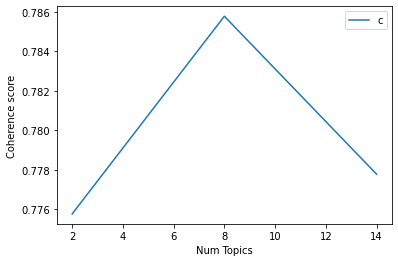

In [140]:
# Show graph
limit=20; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [141]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.7758
Num Topics = 8  has Coherence Value of 0.7858
Num Topics = 14  has Coherence Value of 0.7778
